2025-06-11 10:49:11,941 | INFO    | Stage 14 run folder: outputs_rff\event=2008\20250609
2025-06-11 10:49:16,645 | INFO    | Panel rows kept (years [2004, 2005, 2006, 2007]): 3,130
c:\Users\Jason Pohl\miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



=== Stage 14 – Console Snapshot ===

Sector-Year summary (head):
                sectorname  year  count  median    mean     std
0         Basic Materials  2004    199  0.6788  0.6888  0.1406
1         Basic Materials  2005    114  0.7175  0.7012  0.1354
2         Basic Materials  2006    226  0.6798  0.6921  0.1368
3         Basic Materials  2007    301  0.6913  0.6880  0.0652
4  Communication Services  2004     20  0.7791  0.7239  0.1701
5  Communication Services  2005      6  0.8889  0.8048  0.2091
6  Communication Services  2006     13  0.7843  0.7550  0.1575
7  Communication Services  2007     21  0.7608  0.7598  0.0662

Top-10 Friedman results:
                sector  n_firms  Friedman_χ²   p_value
3              Energy       12       16.000  0.001134
4  Financial Services       87       15.207  0.001648
2  Consumer Defensive        5       15.000  0.001817
5          Healthcare       22        4.909  0.178576
1   Consumer Cyclical        9        3.000  0.391625
7         Real 

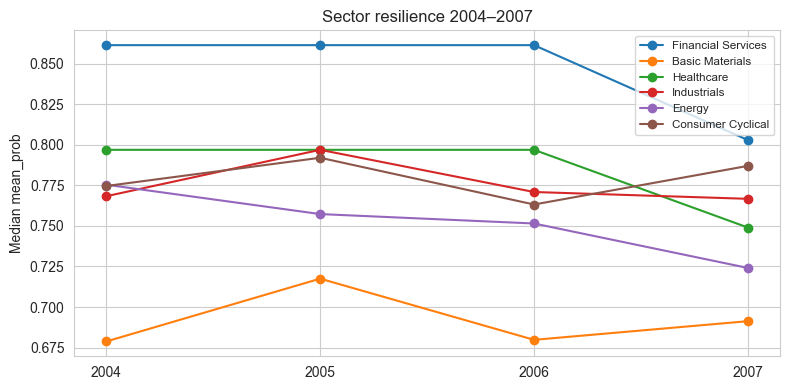

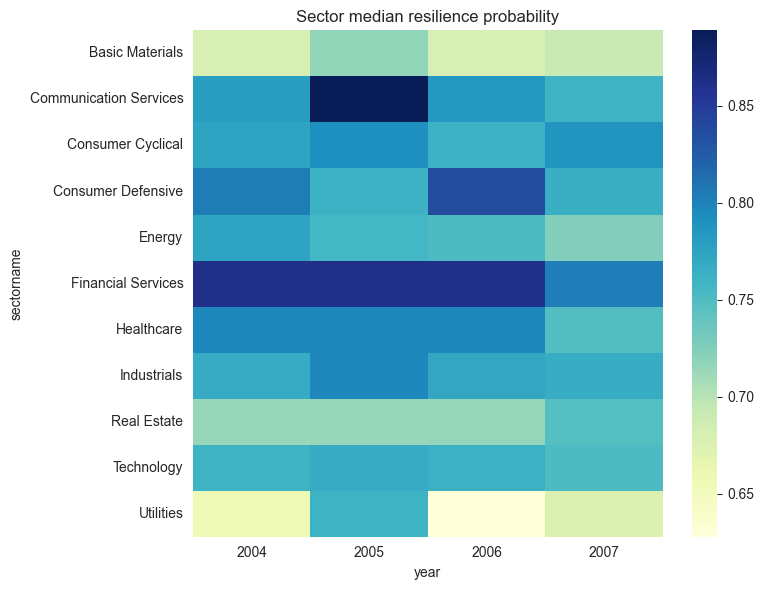

2025-06-11 10:49:17,933 | INFO    | ✓  Stage 14 complete – artefacts written to outputs_rff\event=2008\20250609\stage14



In [3]:
#!/usr/bin/env python
# =====================================================================
#  STAGE 14 · 4-Year Pre-Swan Longitudinal Sector Study   (pipeline-v2)
# =====================================================================
# • 4-year panel (t-4 … t-1) on mean-RISE probability
# • Per-sector Friedman χ² (matched firms only)
# • Mixed-effects: mean_prob ~ year  +  ( 1 | sector )
# • Outputs (<run>/stage14/):
#       Stage14_SectorYearSummary.csv
#       Stage14_SectorYearPivot.csv
#       Stage14_FriedmanPerSector.csv
#       Stage14_MixedModel_Coefficients.csv
#       Stage14_Line_SectorMedians.png      [if PLOT]
#       Stage14_Heatmap_SectorYear.png      [if PLOT]
# =====================================================================

from __future__ import annotations
import os, warnings, logging
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import statsmodels.api as sm
from IPython.display import display   # inline in notebooks

warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.INFO,
    format="%(asctime)s | %(levelname)-7s | %(message)s")
log = logging.getLogger("stage14")

# ── ENV CONFIG ──────────────────────────────────────────────────────
SWAN_YEAR   = int(os.getenv("SWAN_YEAR", 2008))
PRE_YEARS   = [SWAN_YEAR - i for i in range(4, 0, -1)]        # t-4 … t-1
OUTPUT_ROOT = Path(os.getenv("OUTPUT_ROOT", "outputs_rff")).expanduser()

ID_COL      = os.getenv("ID_COL",      "Symbol").lower()
DATE_COL    = os.getenv("DATE_COL",    "ReportDate").lower()
SECTOR_COL  = os.getenv("SECTOR_COL",  "SectorName").lower()

PLOT = os.getenv("PLOT", "1") == "1"        # default show plots

# ── LOCATE RUN FOLDER ───────────────────────────────────────────────
def _env_path(var: str) -> Path | None:
    v = os.getenv(var)
    if v:
        p = Path(v).expanduser()
        if not p.exists():
            raise FileNotFoundError(f"{var}='{p}' not found")
        return p
    return None

if _env_path("RUN_DIR"):
    RUN_DIR = _env_path("RUN_DIR")          # type: ignore
else:
    event_dir = OUTPUT_ROOT / f"event={SWAN_YEAR}"
    cand = sorted(event_dir.glob("*/stage11/*rise*prob*.csv"),
                  key=lambda p: p.stat().st_mtime, reverse=True)
    if not cand:
        raise RuntimeError("No Stage-11 probability files found – run Stage 11 first")
    RUN_DIR = cand[0].parents[1]

STAGE_DIR = RUN_DIR / "stage14"
STAGE_DIR.mkdir(parents=True, exist_ok=True)
log.info("Stage 14 run folder: %s", RUN_DIR)

# ── RESOLVE INPUT FILES ─────────────────────────────────────────────
def _need(env_var: str, canonical: Path, kw: list[str] | None = None) -> Path:
    if _env_path(env_var):
        return _env_path(env_var)           # type: ignore
    if canonical.is_file():
        return canonical
    if kw:
        kws = [k.lower() for k in kw]
        for fp in canonical.parent.glob("*.csv"):
            if all(k in fp.name.lower() for k in kws):
                return fp
    raise FileNotFoundError(f"{canonical.name} (or {env_var}) not found")

RISE_CSV   = _need("RISE_CSV",
                   RUN_DIR / "stage11" / "Stage11_RISE_Probabilities_All.csv",
                   kw=["rise","prob"])
STAGE3_CSV = _need("STAGE3_CSV",
                   RUN_DIR / "stage03" / "Stage3_Data_WithRatios.csv")

# ── LOAD & PREP DATA ────────────────────────────────────────────────
def _ld(fp: Path, dates=False) -> pd.DataFrame:
    df = pd.read_csv(fp, low_memory=False)
    df.columns = df.columns.str.lower().str.strip()
    if dates and DATE_COL in df.columns:
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    return df

rise   = _ld(RISE_CSV,   dates=True)
stage3 = _ld(STAGE3_CSV, dates=True)

if SECTOR_COL not in rise.columns:
    rise = rise.merge(stage3[[ID_COL, SECTOR_COL]].drop_duplicates(),
                      on=ID_COL, how="left")

prob_cols = [c for c in rise.columns if "prob" in c]
if not prob_cols:
    raise RuntimeError("Probability columns missing in Stage-11 file")

rise["mean_prob"] = (rise[prob_cols]
                       .replace([np.inf, -np.inf], np.nan)
                       .mean(axis=1, skipna=True))
rise["year"] = rise[DATE_COL].dt.year

panel = rise[(rise["year"].isin(PRE_YEARS)) & rise["mean_prob"].notna()].copy()
log.info("Panel rows kept (years %s): %s", PRE_YEARS, f"{len(panel):,}")

# ── SUMMARY TABLES ─────────────────────────────────────────────────
summary = (panel.groupby([SECTOR_COL, "year"])["mean_prob"]
                 .agg(['count','median','mean','std'])
                 .round(4).reset_index())
summary.to_csv(STAGE_DIR / "Stage14_SectorYearSummary.csv", index=False)

pivot = summary.pivot(index=SECTOR_COL, columns="year", values="median")
pivot.to_csv(STAGE_DIR / "Stage14_SectorYearPivot.csv")

# ── FRIEDMAN PER SECTOR ────────────────────────────────────────────
fried_rows = []
for sec, g in panel.groupby(SECTOR_COL):
    wide = (g.pivot_table(index=ID_COL, columns="year",
                          values="mean_prob", aggfunc="median")
              .reindex(columns=PRE_YEARS))
    wide = wide.dropna(how="any")
    if len(wide) >= 5:
        stat, p = friedmanchisquare(*[wide[y] for y in PRE_YEARS])
        fried_rows.append({"sector": sec, "n_firms": len(wide),
                           "Friedman_χ²": round(stat, 3), "p_value": p})
fried_df = pd.DataFrame(fried_rows).sort_values("p_value")
fried_df.to_csv(STAGE_DIR / "Stage14_FriedmanPerSector.csv", index=False)

# ── MIXED-EFFECTS MODEL  mean_prob ~ year + (1|sector) ─────────────
panel["year_c"] = panel["year"] - panel["year"].min()
mdl = sm.MixedLM.from_formula("mean_prob ~ year_c",
                              groups=panel[SECTOR_COL],
                              data=panel).fit(reml=False)

# build a DataFrame of coefficients that is version-agnostic
coeff = (pd.DataFrame({
            "Coef"   : mdl.params,
            "StdErr" : mdl.bse,
            "z"      : mdl.tvalues,
            "P>|z|"  : mdl.pvalues
        })
        .round(6)
        .rename_axis("Term"))

coeff.to_csv(STAGE_DIR / "Stage14_MixedModel_Coefficients.csv")

#╔══════════════════════════════════════════════════════════════════╗
# 6 · CONSOLE OUTPUT (matches original notebook feel)                #
# ╚══════════════════════════════════════════════════════════════════╝
print("\n=== Stage 14 – Console Snapshot ===")
print("\nSector-Year summary (head):\n", summary.head(8))
print("\nTop-10 Friedman results:\n", fried_df.head(10))
print("\nMixed-Effects coefficients:\n", coeff, "\n")

# ── OPTIONAL PLOTS  (save + show inline) ───────────────────────────
if PLOT:
    sns.set_style("whitegrid")

    # (a) line plot – top-6 sectors by count
    top6 = (summary.groupby(SECTOR_COL)["count"].sum()
                   .nlargest(6).index.tolist())
    fig, ax = plt.subplots(figsize=(8,4))
    for sec in top6:
        yvals = (summary[summary[SECTOR_COL] == sec]
                           .set_index("year")["median"])
        ax.plot(PRE_YEARS, yvals, marker="o", label=sec)
    ax.set_xticks(PRE_YEARS)
    ax.set_ylabel("Median mean_prob")
    ax.set_title(f"Sector resilience {PRE_YEARS[0]}–{PRE_YEARS[-1]}")
    ax.legend(fontsize="small")
    fig.tight_layout()
    fig.savefig(STAGE_DIR / "Stage14_Line_SectorMedians.png", dpi=110)
    display(fig)
    plt.close(fig)

    # (b) heat-map
    fig2, ax2 = plt.subplots(figsize=(8,6))
    sns.heatmap(pivot, cmap="YlGnBu", annot=False, ax=ax2)
    ax2.set_title("Sector median resilience probability")
    fig2.tight_layout()
    fig2.savefig(STAGE_DIR / "Stage14_Heatmap_SectorYear.png", dpi=110)
    display(fig2)
    plt.close(fig2)

# ── DONE ────────────────────────────────────────────────────────────
log.info("✓  Stage 14 complete – artefacts written to %s\n", STAGE_DIR)


